# Lab 5 - Multivariate Regression, Non-Parametric Models and Cross-Validation

#### Aim : 
To develop a predictive model using the Scikit-Learn Diabetes dataset. Our goal is to construct a univariate polynomial regression model to predict the risk of diabetes progression based on the body mass index (BMI) feature. This model will serve as a valuable screening tool for physicians, enabling them to identify patients at risk of diabetes progression.

#### Evalution metrics :  
* R - Squared 
* MAPE (Mean Absolute Percentage Error)
* MAE  ((Mean Absolute Error))

#### Attributes info
* **age** age in years
* **sex**
* **bmi** body mass index
* **bp** average blood pressure
* **s1** tc, total serum cholesterol
* **s2** ldl, low-density lipoproteins
* **s3** hdl, high-density lipoproteins
* **s4** tch, total cholesterol / HDL
* **s5** ltg, possibly log of serum triglycerides level
* **s6** glu, blood sugar level*
* **target**
<br/>Here, BMI is the independent variable and Target is a quantitative measure of disease progression one year after baseline.

### Getting the data

                age           sex           bmi            bp            s1   
count  4.420000e+02  4.420000e+02  4.420000e+02  4.420000e+02  4.420000e+02  \
mean  -2.511817e-19  1.230790e-17 -2.245564e-16 -4.797570e-17 -1.381499e-17   
std    4.761905e-02  4.761905e-02  4.761905e-02  4.761905e-02  4.761905e-02   
min   -1.072256e-01 -4.464164e-02 -9.027530e-02 -1.123988e-01 -1.267807e-01   
25%   -3.729927e-02 -4.464164e-02 -3.422907e-02 -3.665608e-02 -3.424784e-02   
50%    5.383060e-03 -4.464164e-02 -7.283766e-03 -5.670422e-03 -4.320866e-03   
75%    3.807591e-02  5.068012e-02  3.124802e-02  3.564379e-02  2.835801e-02   
max    1.107267e-01  5.068012e-02  1.705552e-01  1.320436e-01  1.539137e-01   

                 s2            s3            s4            s5            s6   
count  4.420000e+02  4.420000e+02  4.420000e+02  4.420000e+02  4.420000e+02  \
mean   3.918434e-17 -5.777179e-18 -9.042540e-18  9.293722e-17  1.130318e-17   
std    4.761905e-02  4.761905e-02  4.761905e-02  4.

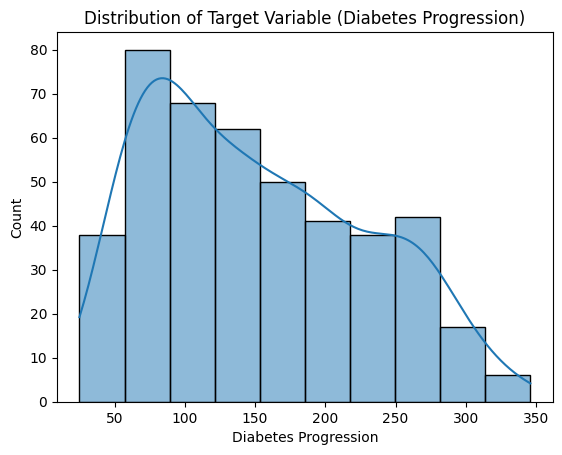

In [111]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import load_diabetes
from sklearn.model_selection import cross_validate
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import r2_score, mean_absolute_error, mean_absolute_percentage_error
from sklearn.model_selection import train_test_split

# Load the diabetes dataset
diabetes = load_diabetes()
X = diabetes.data
y = diabetes.target

# Create a DataFrame for easier analysis
df = pd.DataFrame(data=X, columns=diabetes.feature_names)
df['target'] = y

# Basic statistics
print(df.describe())

# Check for missing values
print(df.isnull())

# Distribution of target variable
sns.histplot(df['target'], kde=True)
plt.title('Distribution of Target Variable (Diabetes Progression)')
plt.xlabel('Diabetes Progression')
plt.ylabel('Count')
plt.show()

### Feature Selection

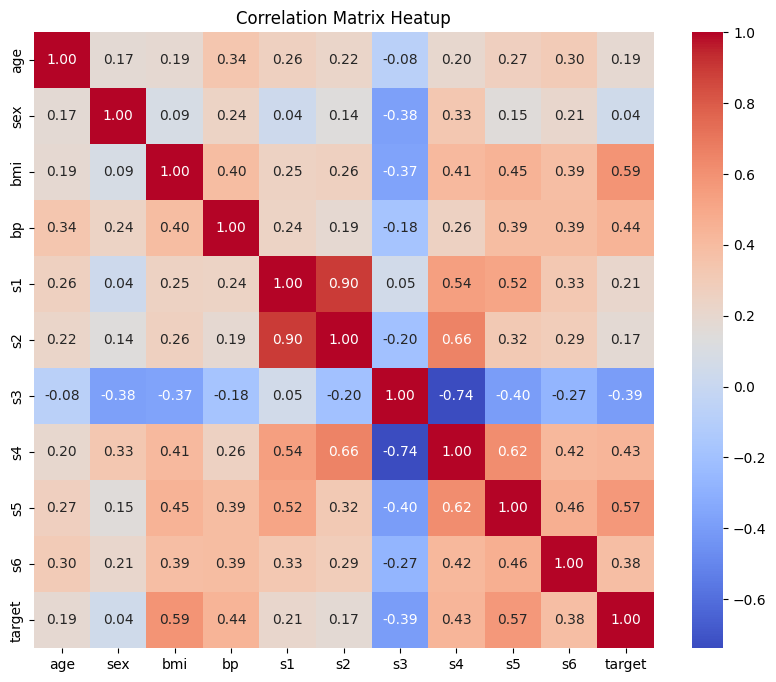

In [112]:
# Correlation with target variable
correlation = df.corr()
plt.figure(figsize=(10,8))
sns.heatmap(correlation, annot=True, cmap='coolwarm', fmt = ".2f")
plt.title('Correlation Matrix Heatup')
plt.show()

These correlation values indicate the strength and direction of the linear relationship between each feature and the target variable. A higher absolute correlation value (closer to 1) suggests a stronger linear relationship, while a value closer to 0 indicates a weaker relationship. Negative values indicate a negative linear relationship, while positive values indicate a positive linear relationship.

Based on these correlation values, "BMI" has the highest correlation with the target variable, followed by "BP" and then "age." This suggests that "BMI" is more strongly correlated with diabetes progression compared to "BP" and "age."

In [113]:
columns_to_drop = ['target', 's1', 's2', 's3']
ndf = df.drop(columns_to_drop, axis=1)

### Train-Test Split

Train/validation set (85%) and a test set (15%), in which training set (70%) and validation set (15%)

In [114]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

### Cross-Validation

In [115]:
# Define models
models = {
    'Polynomial Regression (degree=2)': make_pipeline(PolynomialFeatures(degree=2), LinearRegression()),
    'Polynomial Regression (degree=3)': make_pipeline(PolynomialFeatures(degree=3), LinearRegression()),
    'Decision Tree (max_depth=2)': DecisionTreeRegressor(max_depth=2),
    'Decision Tree (max_depth=5)': DecisionTreeRegressor(max_depth=5),
    'KNN (k=3)': KNeighborsRegressor(n_neighbors=3),
    'KNN (k=5)': KNeighborsRegressor(n_neighbors=5)
}

In [122]:
# Cross-Validation
results = {}
for name, model in models.items():  # Use items() method to iterate over keys and values
    cv_scores = cross_validate(model, X_train, y_train, scoring=('r2', 'neg_mean_absolute_error'), cv=5)
    mape_scores = np.abs((cv_scores['test_neg_mean_absolute_error'] / y_train.mean()) * 100)
    results[name] = {
        'Mean R-squared': cv_scores['test_r2'].mean(),
        'Mean MAE': -cv_scores['test_neg_mean_absolute_error'].mean(),
        'Mean MAPE': mape_scores.mean(),
        'Std R-squared': cv_scores['test_r2'].std(),
        'Std MAE': -cv_scores['test_neg_mean_absolute_error'].std(),
        'Std MAPE': mape_scores.std()
    }

# Create a table summarizing the cross-validation results
results_df = pd.DataFrame.from_dict(results, orient='index')
results_df

,Mean R-squared,Mean MAE,Mean MAPE,Std R-squared,Std MAE,Std MAPE
Polynomial Regression (degree=2),0.096753,55.112201,36.003273,0.134908,-5.217124,3.408202
Polynomial Regression (degree=3),-5068.903139,1732.950576,1132.088578,5335.253310,-707.691511,462.315249
Decision Tree (max_depth=2),0.226862,51.731149,33.794526,0.172037,-2.819632,1.841988
Decision Tree (max_depth=5),-0.041339,59.023062,38.558131,0.329741,-5.331368,3.482835
KNN (k=3),0.140483,53.837102,35.170287,0.178239,-3.608273,2.357184
KNN (k=5),0.258074,50.842759,33.214165,0.152867,-4.208461,2.749271


Based on these comparisons, the KNN (k=5) model stands out as the best performer among the models you evaluated, as it has the highest mean R-squared value and relatively lower mean MAE and mean MAPE values compared to the other models.

In [121]:
# Fit the best model on the entire training data
best_model_name = 'KNN (k=5)'  # Use the name of the model as the key
best_model = models[best_model_name]

# Evaluate on test set
best_model.fit(X_train, y_train)
y_pred = best_model.predict(X_test)
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
mape = mean_absolute_percentage_error(y_test, y_pred)

print(f"R-squared on test set: {r2}")
print(f"MAE on test set: {mae}")
print(f"MAPE on test set: {mape}")

R-squared on test set: 0.5260062866018743
MAE on test set: 45.08648648648649
MAPE on test set: 0.3838261838911328


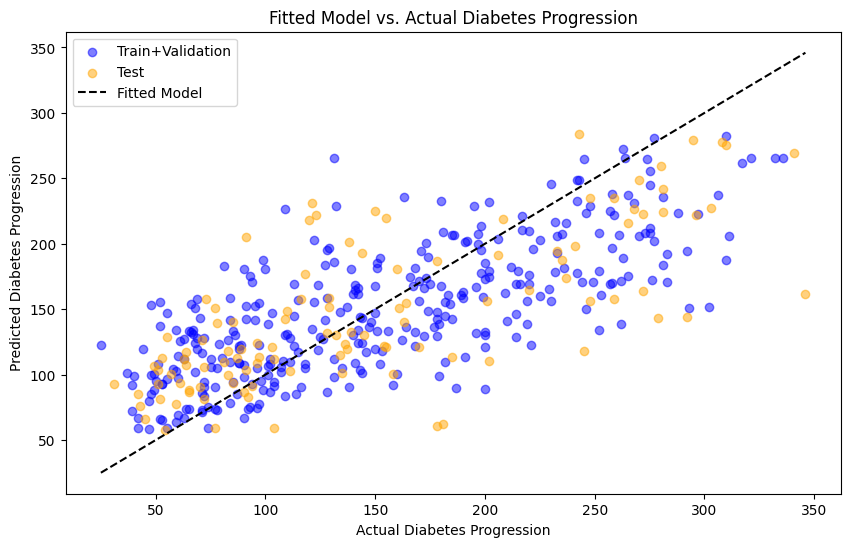

In [125]:
# Plotting the fitted model
plt.figure(figsize=(10, 6))
plt.scatter(y_train, best_model.predict(X_train), label='Train+Validation', color='blue', alpha=0.5)
plt.scatter(y_test, y_pred, label='Test', color='orange', alpha=0.5)
plt.plot([min(y), max(y)], [min(y), max(y)], '--', color='black', label='Fitted Model')
plt.xlabel('Actual Diabetes Progression')
plt.ylabel('Predicted Diabetes Progression')
plt.title('Fitted Model vs. Actual Diabetes Progression')
plt.legend()
plt.show()

Here's a conclusion section based on the provided test set performance metrics for the selected KNN (k=5) model:

**Conclusion:**
The KNN (k=5) model achieved a reasonable performance on the test set, with an R-squared value of approximately 0.53, indicating that the model explains about 53% of the variance in the target variable. The mean absolute error (MAE) on the test set is around 45.09, which represents the average absolute difference between the predicted and actual values. The mean absolute percentage error (MAPE) is approximately 0.38, indicating that, on average, the model's predictions are within 38% of the actual values.

**Model Performance:**
The R-squared value suggests that the model captures a moderate amount of variability in the target variable. However, there is still a significant portion of the variability that remains unexplained by the model. The MAE and MAPE values indicate that the model's predictions have a moderate level of accuracy, with the MAE indicating the average magnitude of errors and the MAPE providing a percentage measure of the errors relative to the actual values.

**Model Limitations and Failure Points:**
- **Limited Predictive Power:** The moderate R-squared value indicates that the model's predictive power is limited, as it does not capture a substantial portion of the variability in the target variable. This limitation suggests that the model may not be able to accurately predict the target variable in all cases.
- **Sensitivity to Hyperparameters:** KNN models are sensitive to the choice of the number of neighbors (k). In this case, using k=5 yielded the best performance, but different values of k could result in different performance outcomes.
- **Assumption of Local Similarity:** KNN assumes that similar instances tend to have similar target values. If this assumption does not hold well in the dataset, the model's predictions may be less accurate.

**Overall Assessment:**
The KNN (k=5) model provides a reasonable level of predictive performance on the test set, but it has limitations in capturing all the variability in the target variable. Further exploration and refinement of the model, including hyperparameter tuning and feature engineering, may improve its performance. Additionally, considering other machine learning algorithms or ensemble methods could be beneficial to compare and potentially enhance predictive capabilities.